In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from matplotlib.patches import Rectangle
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import to_rgb
from matplotlib.patches import PathPatch
from matplotlib.legend_handler import HandlerTuple

In [2]:
# Load datasets
path = "../Data/"
tm_2022 = pd.read_csv("{}team_stats_2021_2022.csv".format(path), sep=';', encoding='latin-1') 
tm_2023 = pd.read_csv("{}team_stats_2022_2023.csv".format(path), sep=';', encoding='latin-1')

In [3]:
# Define functions for data processing and plotting
def label_rk(rank):
    labels = ["Top 5", "Top 10", "Top 15", "Top 20"]
    RkLg = np.arange(6, 22, 5)
    idx = np.where(rank < RkLg)[0][0]
    return labels[idx]

In [4]:
# Process datasets
data = [tm_2022, tm_2023]
for i in range(2):
   data[i]["Top_Team_Scorer_name"] = data[i]["Top Team Scorer"].apply(lambda x: " ".join(x.split(" ")[:-2]))
   data[i]["Top_Team_Scorer_goals"] = data[i]["Top Team Scorer"].apply(lambda x: x.split(" ")[-1]).astype("int64")
   data[i]["Top_Team_Scorer_contribution"] = data[i]["Top_Team_Scorer_goals"]/data[i]["GF"]
   data[i]["LgRk_label"] = data[i]["LgRk"].apply(label_rk)
   data[i]["GD_xGD_diff"] = data[i]["GD"]- data[i]["xGD"]

tm_2022.rename(columns = {"Pts/G":"Pts/MP"}, inplace=True)
del tm_2022["Top Team Scorer"], tm_2023["Top Team Scorer"]

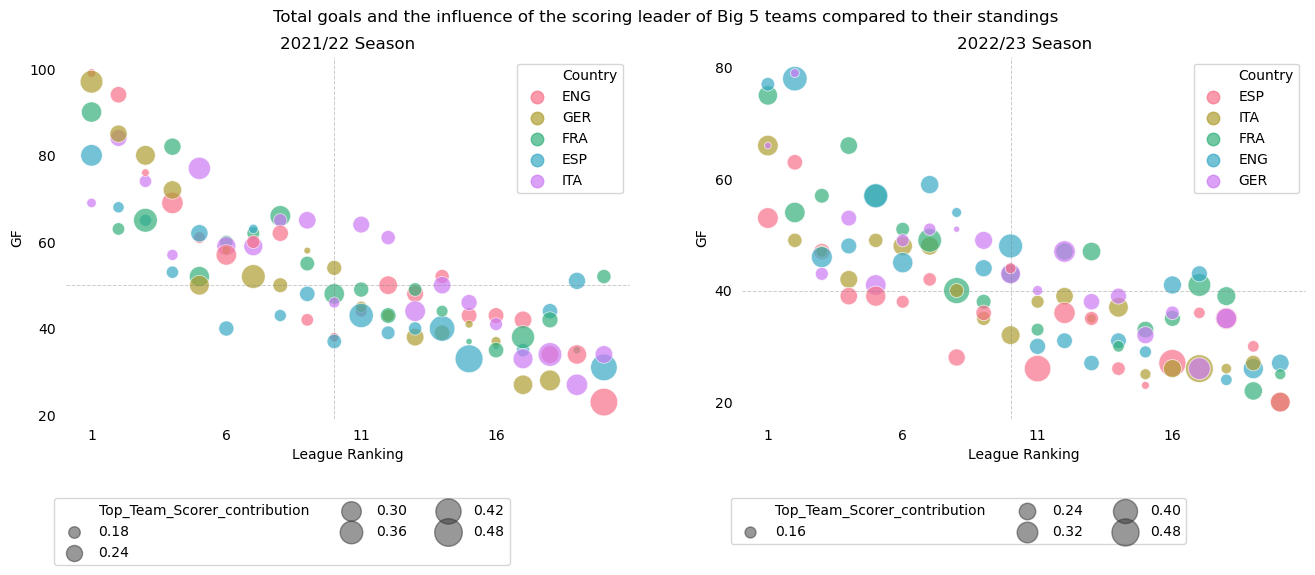

In [301]:
fig, ax = plt.subplots(1, 2, figsize = (16, 4.7))
y_ticks = [range(20, 110, 20), range(20, 90, 20)]
data = [tm_2022, tm_2023]
title = ["2021/22", "2022/23"]
for i in range(2):
    sns.scatterplot(data=data[i], x="LgRk", y="GF", size="Top_Team_Scorer_contribution", hue="Country", alpha=0.7,
                    legend=True, palette="husl", sizes=(20, 400), ax=ax[i])
    ax[i].set_xticks(range(1, 21, 5), labels=range(1, 21, 5))
    ax[i].set_yticks(y_ticks[i], labels=y_ticks[i])
    ax[i].axvline(10, color='gray', linestyle='--', linewidth=0.7, alpha=0.4)
    ax[i].axhline(np.round(np.median(data[i].GF)), color='gray', linestyle='--', linewidth=0.7, alpha=0.4)
    ax[i].tick_params(left=False, bottom=False)
    ax[i].set_title("{} Season".format(title[i]))
    ax[i].set_xlabel("League Ranking")
    handles, labels = ax[i].get_legend_handles_labels()
    ax[i].legend().remove()
    [hand.set_alpha(0.7) for hand in handles[:6]]
    legend = ax[i].legend(handles=handles[:6], labels=labels[:6], markerscale=1.5, loc="best", ncol=1)
    ax[i].add_artist(legend)
    [hand.set_alpha(0.5) for hand in handles[6:]]
    ax[i].legend(handles=handles[6:], labels=labels[6:], bbox_to_anchor=(0.8, -0.2), ncol=3)
    

sns.despine(top=True, left=True, bottom=True, right=True)
plt.suptitle("Total goals and the influence of the scoring leader of Big 5 teams compared to their standings")
plt.show()

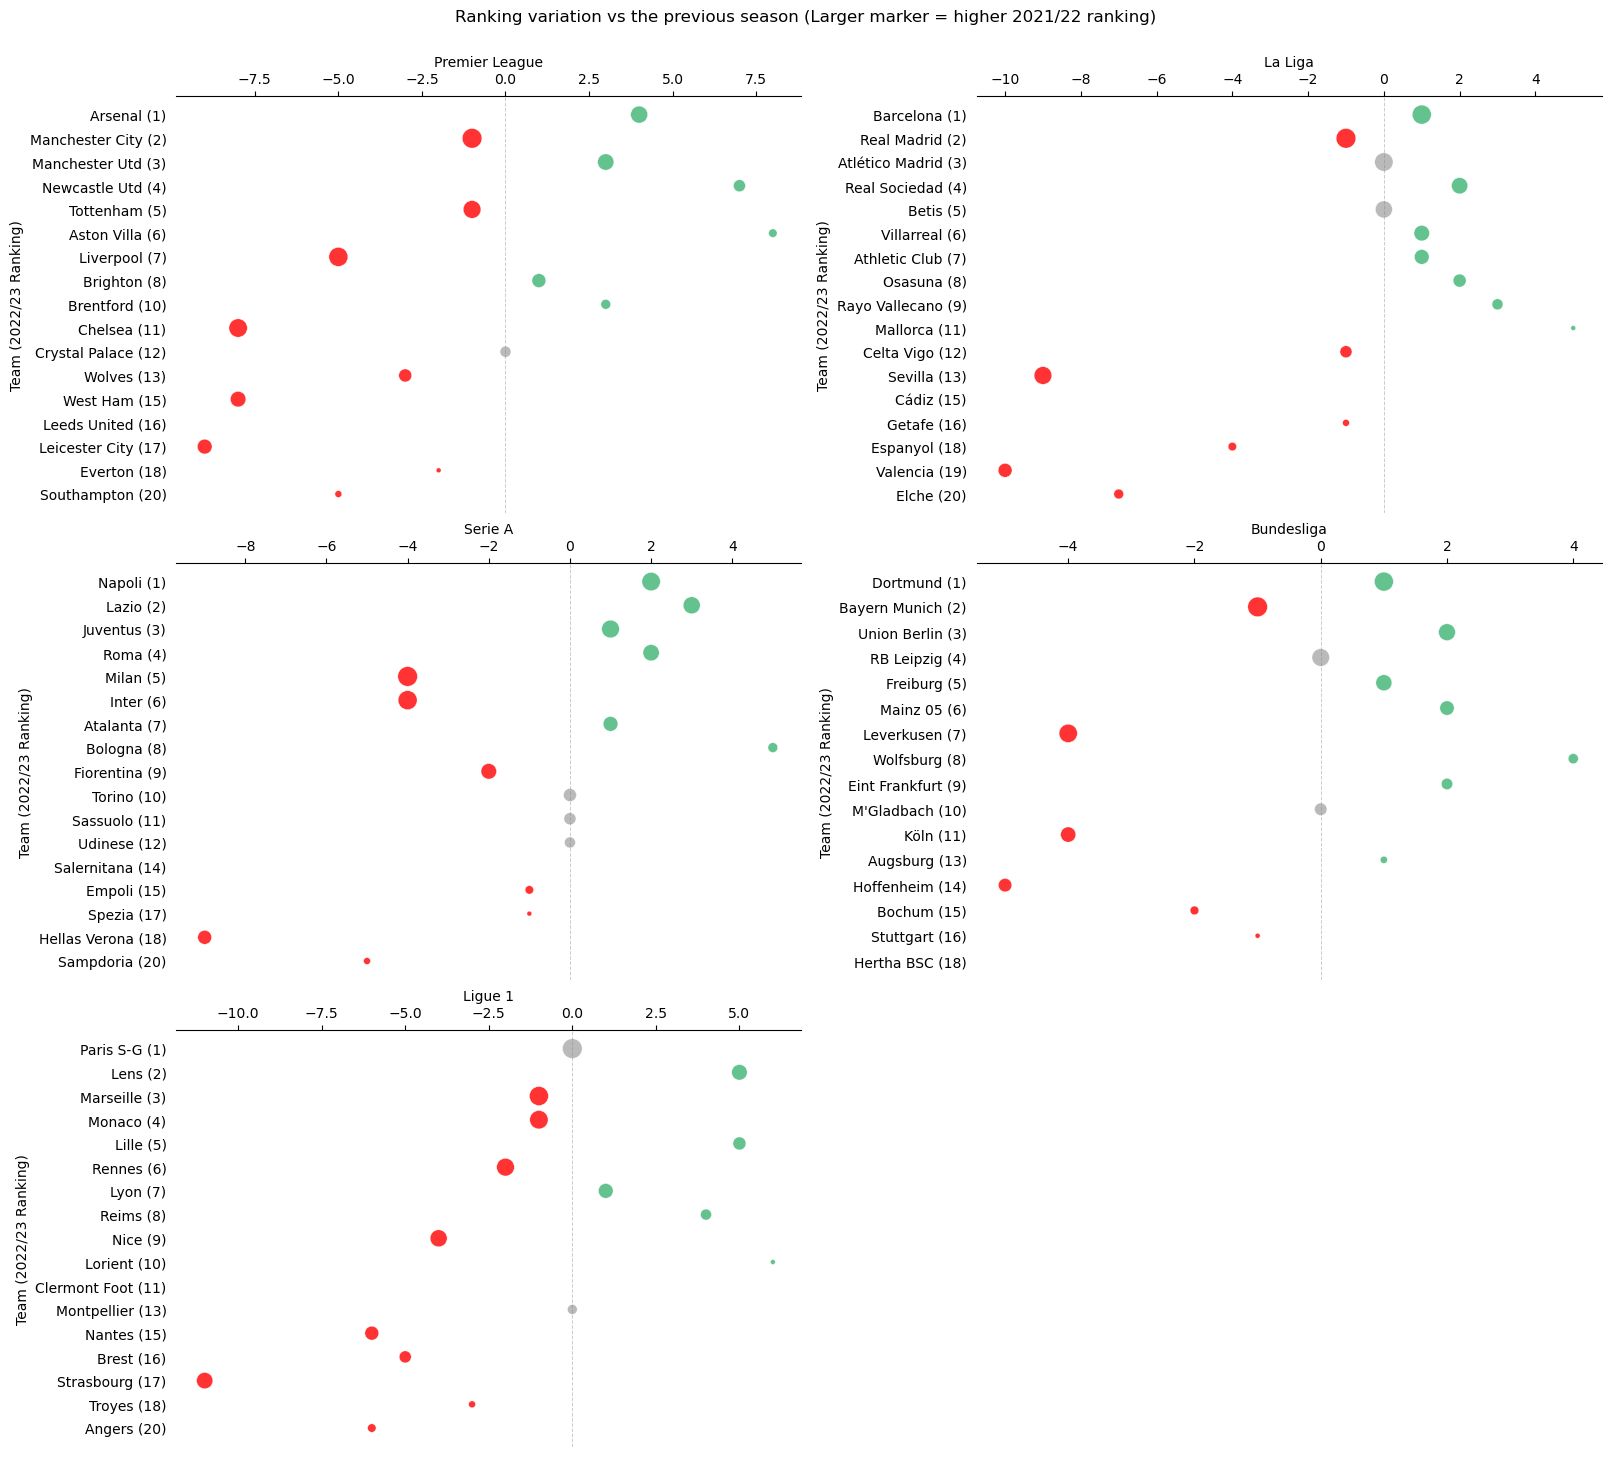

In [197]:
fig, ax = plt.subplots(3, 2, figsize = (16, 14), layout='constrained')
ax[2,1].axis("off")
d_country = {0:['ENG', 'ESP'], 1:['ITA', 'GER'], 2:['FRA']}
d_league = {'ENG': 'Premier League', 'ESP': 'La Liga', 'ITA': 'Serie A', 'GER': 'Bundesliga', 'FRA': 'Ligue 1'}
colors = {-1:"red", 0:"darkgrey", 1:"mediumseagreen"}

for i in range(5):
    country = d_country[i//2][i%2]
    teams_22 = set(tm_2022[tm_2022.Country == country].Squad)
    teams_23 = set(tm_2023[tm_2023.Country == country].Squad)
    rk_2023 = tm_2023[tm_2023.Squad.apply(lambda x: x in (teams_22 & teams_23))].sort_values(by="LgRk").Squad.values
    rk_diff = {squad : tm_2022[tm_2022.Squad==squad].LgRk.iloc[0] - tm_2023[tm_2023.Squad==squad].LgRk.iloc[0] for squad in (teams_22 & teams_23)}
    df_tmp = pd.DataFrame(rk_diff, index = np.arange(1)).T.rename(columns = {0: "Rk_diff"})
    df_tmp["color_enc"] = df_tmp["Rk_diff"].apply(lambda x: 1*(x>0) -1*(x<0))
    df_tmp["Squad"] = df_tmp.index
    df_tmp["Rk_2022_size"] = df_tmp.Squad.apply(lambda x: 500 - 20*tm_2022[tm_2022.Squad==x].LgRk.iloc[0])
    df_tmp["Rk_2023_label"] = df_tmp.Squad.apply(lambda x: x + " ({})".format(str(tm_2023[tm_2023.Squad==x].LgRk.iloc[0])))
    
    sns.scatterplot(df_tmp.loc[rk_2023,:], x ="Rk_diff", y="Rk_2023_label", hue="color_enc", legend=False, \
                    palette=colors, alpha=0.8, size='Rk_2022_size', sizes=(0, 200), marker="o", ax=ax[i//2, i%2])
    ax[i//2, i%2].axvline(0, color='gray', linestyle='--', linewidth=0.7, alpha=0.4)
    ax[i//2, i%2].set_xlabel("{}".format(d_league[country]))
    ax[i//2, i%2].xaxis.set_label_position('top')
    ax[i//2, i%2].set_ylabel("Team (2022/23 Ranking)") 
    ax[i//2, i%2].tick_params(bottom=False, labelbottom=False, top=True, labeltop=True, left=False)
    ax[i//2, i%2].spines[['right', 'left', 'bottom']].set_visible(False)

plt.suptitle("Ranking variation vs the previous season (Larger marker = higher 2021/22 ranking)", y=1.03)
plt.show()
del teams_22, teams_23, rk_diff, df_tmp

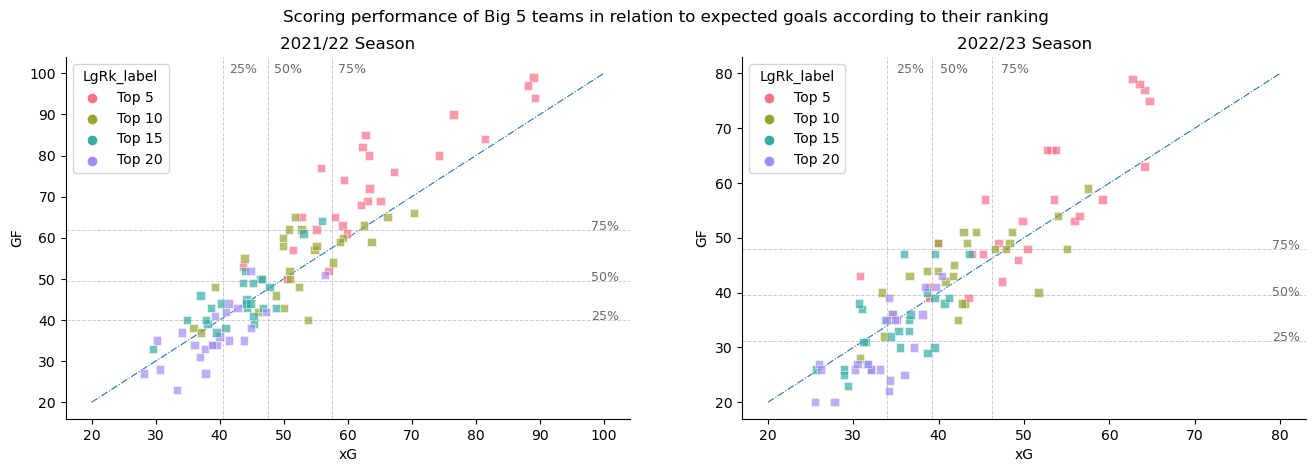

In [349]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4.7))
data = [tm_2022, tm_2023]
line = [np.linspace(20, 100, 2), np.linspace(20, 80, 2)]
x_text, y_text = [98, 79], [100, 80]
title = ["2021/22", "2022/23"]
for i in range(2):
    sns.scatterplot(data=data[i], x="xG", y="GF", hue="LgRk_label", alpha=0.7, marker="s", legend=True, palette="husl", ax=ax[i], zorder=2)
    ax[i].plot(line[i], line[i], linestyle="-.", linewidth=0.8, zorder=1)
    ax[i].set_title("{} Season".format(title[i]))
    for q in np.arange(0.25, 1, 0.25):
        ax[i].axvline(np.quantile(data[i].xG, q), color='gray', linestyle='--', linewidth=0.7, alpha=0.4)
        ax[i].text(np.quantile(data[i].xG, q)+1, y_text[i], f"{int(100*q)}%", size=9, color="dimgrey")
        ax[i].axhline(np.quantile(data[i].GF, q), color='gray', linestyle='--', linewidth=0.7, alpha=0.4)
        ax[i].text(x_text[i], np.quantile(data[i].GF, q), f"{int(100*q)}%", size=9, color="dimgrey")
    
sns.despine()
plt.suptitle("Scoring performance of Big 5 teams in relation to expected goals according to their ranking")
plt.show()

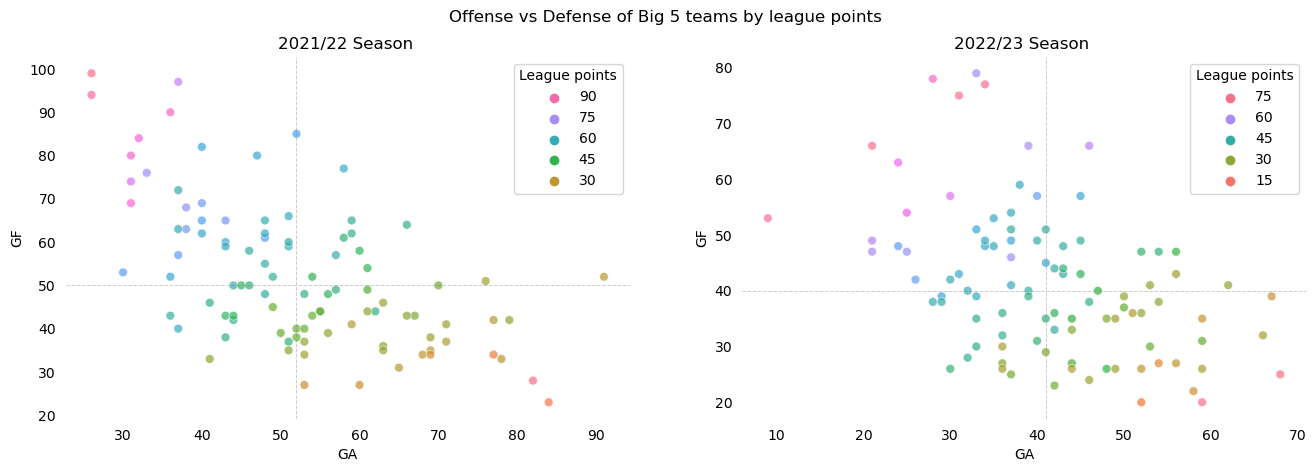

In [314]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4.7))
data = [tm_2022, tm_2023]
title = ["2021/22", "2022/23"]
for i in range(2):
    sns.scatterplot(data=data[i], x="GA", y="GF", hue="Pts", alpha=0.7, legend=True, palette="husl", s=40, ax=ax[i])
    ax[i].axhline(np.round(np.median(data[i].GF)), color='gray', linestyle='--', linewidth=0.7, alpha=0.4)
    ax[i].axvline(np.round(np.median(data[i].GA)), color='gray', linestyle='--', linewidth=0.7, alpha=0.4)
    ax[i].tick_params(left=False, bottom=False)
    ax[i].set_title("{} Season ".format(title[i]))
    ax[i].legend(title="League points", reverse=True)

sns.despine(top=True, left=True, bottom=True, right=True)
plt.suptitle("Offense vs Defense of Big 5 teams by league points") 
plt.show()

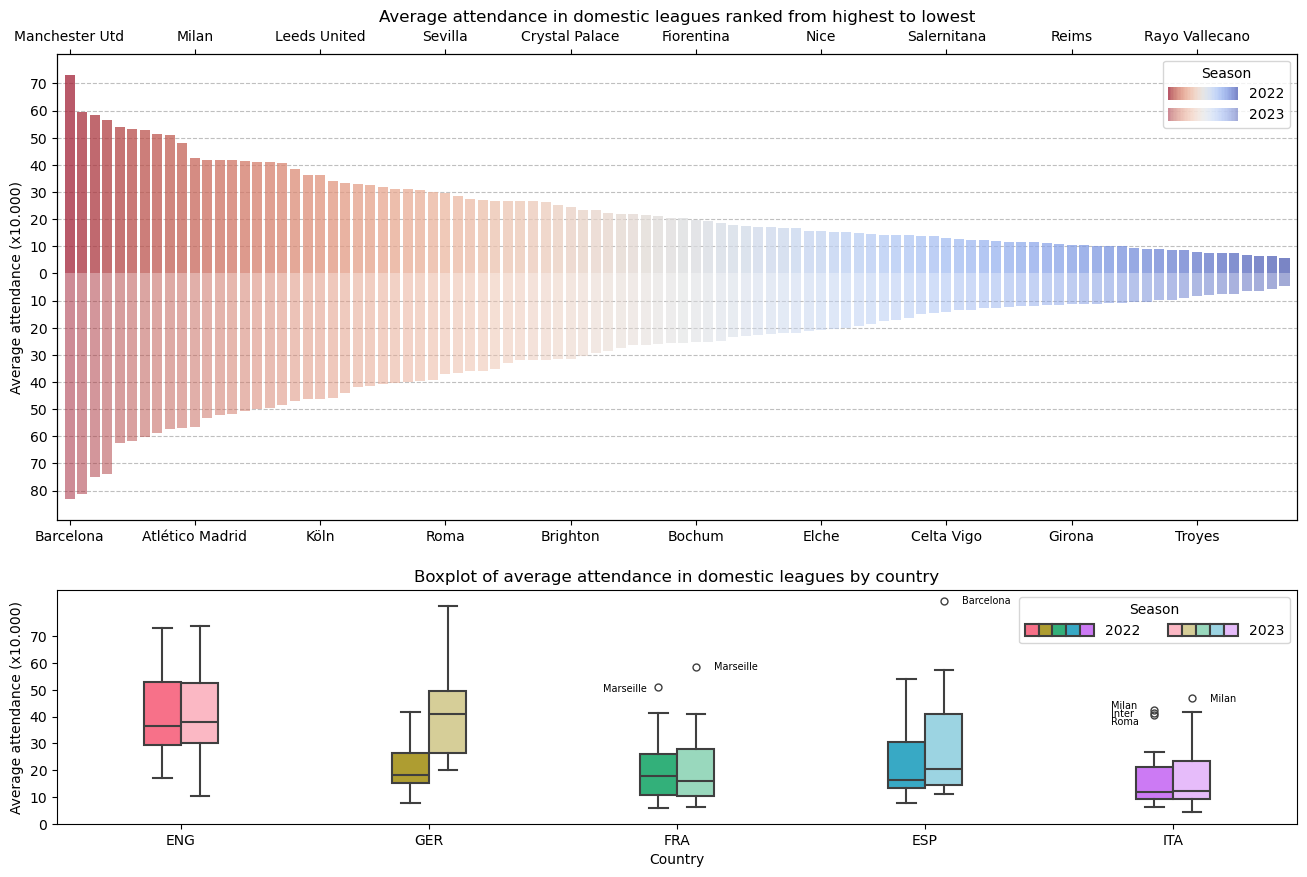

In [133]:
fig, ax = plt.subplots(2, 1, figsize=(16, 10), gridspec_kw={'height_ratios': [2, 1]})
# Upper figure
tm_2023.Attendance = tm_2023.Attendance.apply(lambda x: x*(-1))

sns.barplot(tm_2022.sort_values(by="Attendance", ascending=False), x="Squad", y="Attendance",
            palette="coolwarm_r", alpha=0.75, lw=0, ax=ax[0], zorder=3)

sns.barplot(tm_2023.sort_values(by="Attendance"), x="Squad", y="Attendance", 
            palette="coolwarm_r", alpha=0.52, lw=0, ax=ax[0], zorder=3)

ax[0].set_xticks(range(0, len(tm_2022)+1, 10), labels=tm_2022.sort_values(by="Attendance", ascending=False).Squad.values[::10], rotation = 0)
ax[0].set_yticks(range(-80000, 75000, 10000), labels=list(range(10, 85, 10))[::-1] + list(range(0, 75, 10)))
ax_ = ax[0].twiny()
ax[0].tick_params(labelbottom=False, bottom=False, labeltop=True, top=True)
ax_.tick_params(labelbottom=True, bottom=True, labeltop=False, top=False)
ax_.set_xticks(range(0, len(tm_2023)+1, 10), labels=tm_2023.sort_values(by="Attendance").Squad.values[::10], rotation = 0)
ax[0].set_xlabel("")
ax[0].set_ylabel("Average attendance (x10.000)")
ax[0].set_title("Average attendance in domestic leagues ranked from highest to lowest")
ax[0].set_xlim(-1, len(tm_2022))
ax[0].axhline(0, color="white", linewidth=2)
ax[0].grid(axis='y', linestyle='dashed', alpha=0.8, zorder=0)

ax_.set_xlim(-1, len(tm_2023))
handles = [tuple([p for p in ax[0].patches][98*i:98*(i+1):2]) for i in range(2)]
ax[0].legend(handles=handles, labels = ["2022", "2023"], title="Season", 
              handlelength=5, handleheight=1, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)})
tm_2023.Attendance = tm_2023.Attendance.apply(lambda x: x*(-1))

tm_2022.insert(0, "Season", 2022)
tm_2023.insert(0, "Season", 2023)

# Lower figure  
df_tmp = pd.concat([tm_2022, tm_2023])
hue_order = ['2022', '2023']
colors = sns.color_palette("husl", 5)

sns.boxplot(df_tmp, x="Country", y="Attendance", hue="Season", width=0.3, saturation=0.5, ax=ax[1], 
            flierprops={"marker": "o", "markerfacecolor":"None"})

# Custom box colors
box_colors = [f + (1 - f) * np.array(to_rgb(c))
              for c in colors for f in np.linspace(0, 0.5, len(hue_order))]

box_patches = [p for p in ax[1].patches if isinstance(p, PathPatch)]

for patch, c in zip(box_patches, box_colors):
    patch.set_facecolor(c)

for collection, color in zip(ax[1].collections, box_colors):
    collection.set_facecolor(color)

# Text annotations for outliers
annotate = {"x": [1.7, 2.15, 3.15, 3.75, 3.75, 3.75, 4.15], 
            "y": [int(x*1000) for x in [49.4, 57.55, 82, 43, 40, 37, 45.7]],
            "s": ["Marseille", "Marseille", "Barcelona", "Milan", "Inter", "Roma", "Milan"]}

for x, y, s in zip(annotate["x"], annotate["y"], annotate["s"]):
    ax[1].text(x=x, y=y, s=s, fontsize=7)

ax[1].set_yticks(range(0, 75000, 10000), labels=range(0, 75, 10))
ax[1].set_ylabel("Average attendance (x10.000)")
ax[1].set_title("Boxplot of average attendance in domestic leagues by country")

handles = [tuple(box_patches[i::len(hue_order)]) for i in range(len(hue_order))]
ax[1].legend(handles=handles, labels=hue_order, title="Season", ncol=2,
          handlelength=5, handleheight=1, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)})

plt.show()

del tm_2022["Season"], tm_2023["Season"]

In [304]:
scaler = StandardScaler()
tsne = TSNE(n_components=2)
pca = PCA(n_components=2)
data = pd.DataFrame(scaler.fit_transform(tm_2022[[col for col in tm_2022.columns if col not in \
                ["Rk", "Country", "Squad", "Goalkeeper", "Top_Team_Scorer_name", "LgRk_label"]]]))

X_train_tsne = tsne.fit_transform(data)
X_train_pca = pca.fit_transform(data)

tm_2022[["tsne_A", "tsne_B"]] = X_train_tsne
tm_2022[["pca_A", "pca_B"]] = X_train_pca

In [12]:
%%time
info = {"eps":[], "min_samples":[], "labels":[]}
for eps in np.arange(0.25, 10.25, 0.5):
    for min_samples in range(3, 16):
        dbscan_model = DBSCAN(eps=eps, min_samples=min_samples).fit(data)
        info["eps"].append(eps)
        info["min_samples"].append(min_samples)
        info["labels"].append(len(set(dbscan_model.labels_)))
info = pd.DataFrame(info)

CPU times: total: 41.4 s
Wall time: 6.57 s


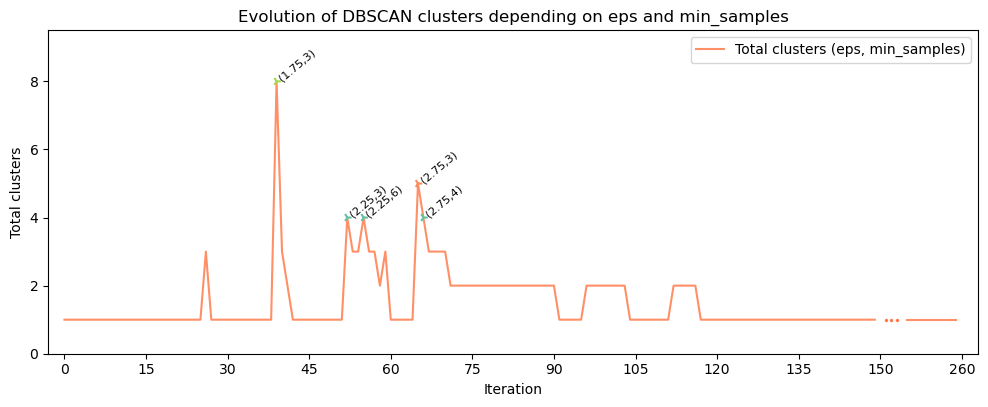

In [430]:
fig, ax = plt.subplots(figsize = (12, 4.2))
colors = sns.color_palette("Set2", 5)
col = {x:c for x,c in zip(range(4, 9), colors)}
c_map = [col[lab] for lab in info[info.labels > 3].labels]
ax.plot(np.arange(150), info.labels.iloc[:150], c='orangered', alpha=0.6)
ax.plot(np.arange(151, 154), np.ones(3), c='orangered', alpha=0.6, marker='.', markersize=3, linestyle='none')
ax.plot(np.arange(155, 165), info.labels.iloc[-10:], c='orangered', alpha=0.6)
ax.scatter(np.where(info.labels.values > 3)[0], info[info.labels > 3].labels, marker ='4', c=c_map, s=40, zorder=4)
for x, y, eps, min_samples in zip(np.where(info.labels.values > 3)[0], info[info.labels > 3].labels, 
                                  info[info.labels > 3].eps, info[info.labels > 3].min_samples):
    ax.text(x+0.1, y, s="({},{})".format(eps, min_samples), rotation=40, fontsize=8)

ax.set_xticks(list(np.arange(170)[::15]), labels=list(np.arange(160)[::15])+[260])
ax.set_xlim(-3, 168)
ax.set_ylim(0, info.labels.max()+1.5)
ax.legend(labels=["Total clusters (eps, min_samples)"])
ax.set_ylabel("Total clusters")
ax.set_xlabel("Iteration")
ax.set_title("Evolution of DBSCAN clusters depending on eps and min_samples")
plt.show()

In [305]:
dbscan_model = DBSCAN(eps=2.75, min_samples=3).fit(data)
kmeans_model = KMeans(n_clusters=4, n_init='auto').fit(data)
pred = kmeans_model.predict(data)
tm_2022["dbscan_labels"] = dbscan_model.labels_
tm_2022["kmeans_labels"] = pred

C:\Users\Achraf\Anaconda\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


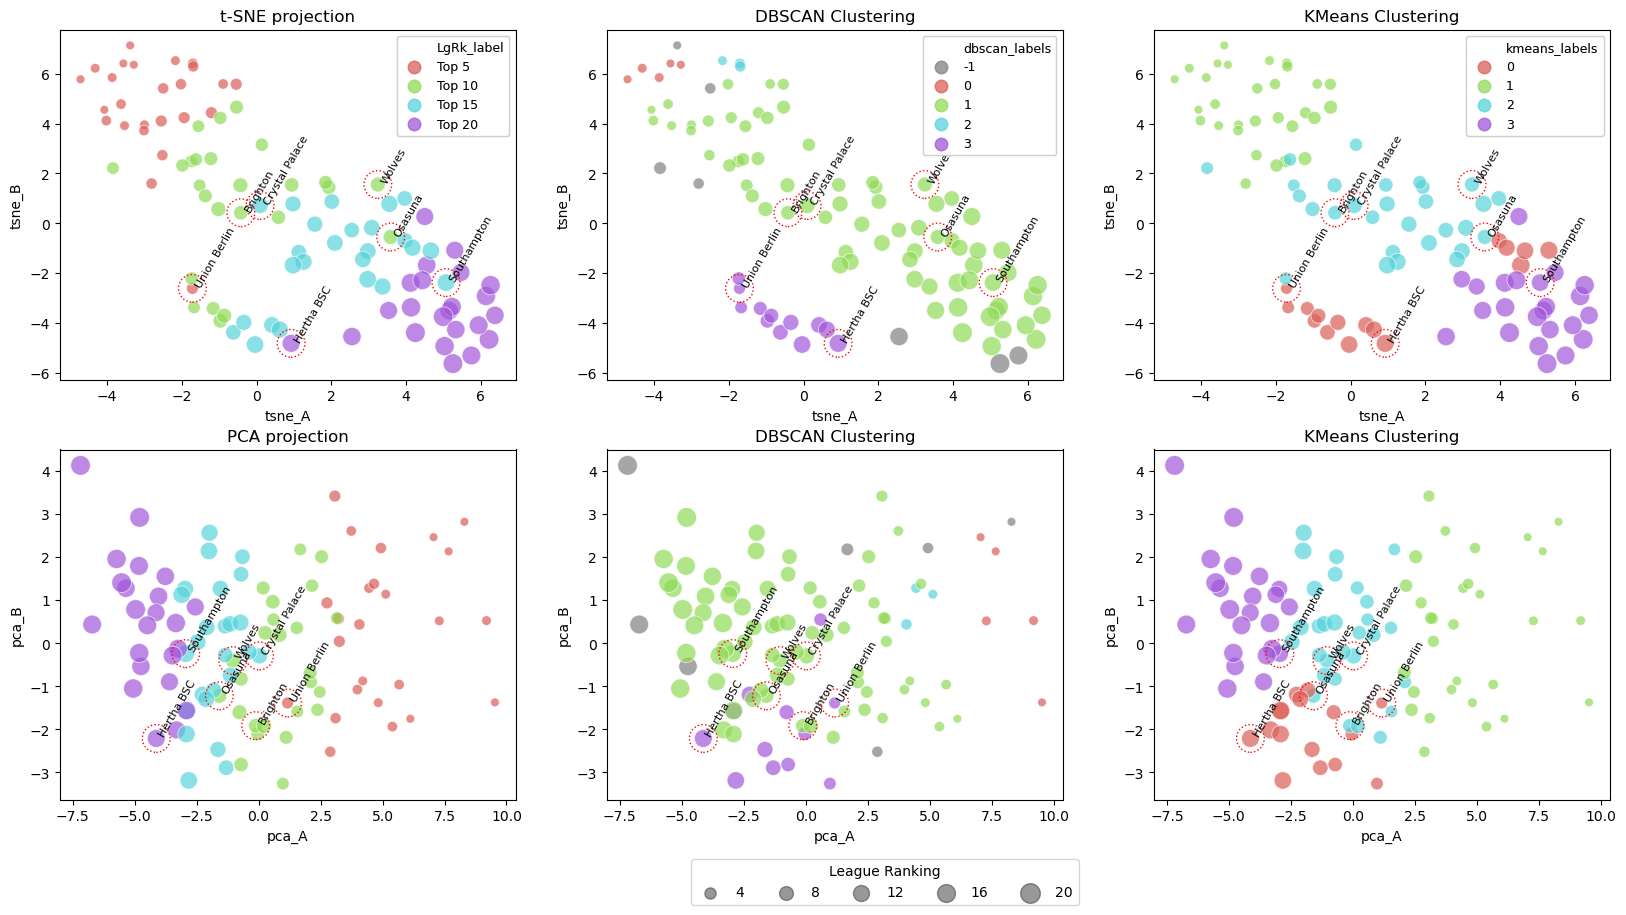

In [405]:
fig, ax = plt.subplots(2, 3, figsize = (20, 10))
# Color palettes
colors = sns.color_palette("hls", 4)
d_color = ["gray"]+[colors[i] for i in range(4)]
palette = ["hls", sns.color_palette(d_color, 5), colors]
# Parameters
anomalies = ["Union Berlin"] + \
["Brighton", "Osasuna", "Wolves"] + \
["Crystal Palace", "Southampton"] + \
["Hertha BSC"]
x, y = ["tsne_A", "pca_A"], ["tsne_B", "pca_B"]
h = ["LgRk_label", "dbscan_labels", "kmeans_labels"]
titles = ["t-SNE projection", "DBSCAN Clustering", "KMeans Clustering", "PCA projection", "DBSCAN Clustering", "KMeans Clustering"]
# PLots
for i in range(6):
    sns.scatterplot(tm_2022, x=x[i//3], y=y[i//3], hue=h[i%3], marker="o", size="LgRk", palette=palette[i%3],
                alpha=0.7, sizes=(40, 200), ax=ax.flatten()[i])
    if i//3 == 0:
        handles, labels = ax.flatten()[i].get_legend_handles_labels()
        ax.flatten()[i].legend().remove()
        [hand.set_alpha(0.7) for hand in handles[:-6]]
        legend = ax.flatten()[i].legend(handles=handles[:-6], labels=labels[:-6], markerscale=1.5, loc="best",
                                    prop={'size': 9}, ncol=1)
        ax.flatten()[i].add_artist(legend)
        [hand.set_alpha(0.5) for hand in handles[-5:]]
    else:
        ax.flatten()[i].legend().remove()
ax.flatten()[-1].legend(handles=handles[-5:], labels=labels[-5:], title="League Ranking", bbox_to_anchor=(-0.15, -0.15), ncol=6)
# Annotations
for team in anomalies:
    for i, ax_ in enumerate(ax.flatten()):
        ax_.set_title(titles[i])
        if i//3==0:
            x, y = tm_2022[tm_2022.Squad == team].tsne_A.values, tm_2022[tm_2022.Squad == team].tsne_B.values
            ax_.text(x + 0.05, y + 0.05, team, fontsize=8, rotation=60)
            ax_.scatter(x, y, s=400, facecolors="None", edgecolors="r", linestyle=":")
        else:
            x, y = tm_2022[tm_2022.Squad == team].pca_A.values, tm_2022[tm_2022.Squad == team].pca_B.values
            ax_.text(x + 0.05, y + 0.05, team, fontsize=8, rotation=60)
            ax_.scatter(x, y, s=400, facecolors="None", edgecolors="r", linestyle=":")

plt.show()